Project: Simulating Life Under Lake Vostok

Course: Advanced Simulation and Modelling

Objective:To simulate the biological dynamics of Lake Vostok, a subglacial lake buried under 4km of ice in Antarctica. We will model the transition from an open lake system to a sealed ecosystem using Monod Kinetics, and then use a Neural Network (LSTM) to predict the future stability of this life.The Mathematical ModelInstead of standard predator-prey models, we use Monod Kinetics, which models microbial growth based on limited resources (nutrients).$$\frac{dR}{dt} = \text{Inflow} - \frac{1}{Y} \cdot \mu_{max} \frac{R}{K_s + R} B$$$$\frac{dB}{dt} = \left( \mu_{max} \frac{R}{K_s + R} \right) B - m \cdot B$$

$R$: Resources (Nutrients/Oxygen)

$B$: Biomass (Bacteria)

$\mu_{max}$: Maximum growth rate

$K_s$: Half-saturation constantInflow: Changes from High (Open Lake) to Low (Sealed Lake) at Year 500.

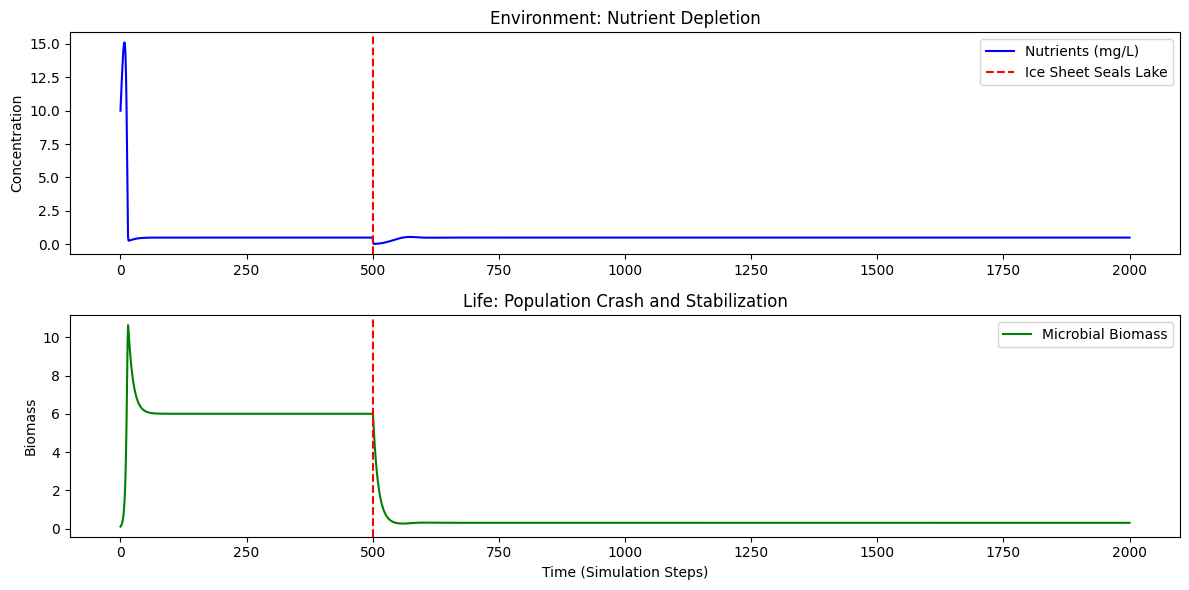

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# --- 1. DEFINE THE MODEL EQUATIONS ---
def vostok_ecosystem(state, t, params):
    # Unpack state variables
    Nutrients = state[0]
    Bacteria = state[1]

    # Unpack parameters
    growth_rate = params['mu_max']
    half_sat = params['Ks']
    yield_coeff = params['Y']
    mortality = params['m']

    # DYNAMIC PARAMETER: The "Sealing" Event
    # At time=500, the ice sheet seals the lake, cutting off nutrient inflow.
    if t < 500:
        inflow = 1.0  # Open lake (sediment transport, runoff)
    else:
        inflow = 0.05 # Sealed lake (only slow melting of ice / geothermal)

    # Monod Growth Equation
    # Growth rate depends on available nutrients
    current_growth = growth_rate * (Nutrients / (half_sat + Nutrients))

    # Differential Equations
    dNutrients_dt = inflow - (1 / yield_coeff) * current_growth * Bacteria
    dBacteria_dt = (current_growth * Bacteria) - (mortality * Bacteria)

    return [dNutrients_dt, dBacteria_dt]

# --- 2. SET SIMULATION PARAMETERS ---
# Initial State [Nutrients, Bacteria]
state0 = [10.0, 0.1]

# Time steps (0 to 2000 years/units)
t = np.linspace(0, 2000, 2000)

# Biological Parameters
params = {
    'mu_max': 0.5,  # Max growth speed
    'Ks': 2.0,      # Efficiency (lower = better at low food)
    'Y': 0.6,       # Yield (mass created per nutrient eaten)
    'm': 0.1        # Death rate
}

# --- 3. RUN SIMULATION ---
solution = odeint(vostok_ecosystem, state0, t, args=(params,))
nutrients_over_time = solution[:, 0]
bacteria_over_time = solution[:, 1]

# --- 4. VISUALIZE RESULTS ---
plt.figure(figsize=(12, 6))

# Plot Nutrients
plt.subplot(2, 1, 1)
plt.plot(t, nutrients_over_time, 'b-', label='Nutrients (mg/L)')
plt.axvline(x=500, color='r', linestyle='--', label='Ice Sheet Seals Lake')
plt.ylabel('Concentration')
plt.title('Environment: Nutrient Depletion')
plt.legend()

# Plot Life
plt.subplot(2, 1, 2)
plt.plot(t, bacteria_over_time, 'g-', label='Microbial Biomass')
plt.axvline(x=500, color='r', linestyle='--')
plt.xlabel('Time (Simulation Steps)')
plt.ylabel('Biomass')
plt.title('Life: Population Crash and Stabilization')
plt.legend()

plt.tight_layout()
plt.show()

Artificial Intelligence Prediction

AI Forecasting with LSTM

Now that we have simulated the history of the lake, we will use a Long Short-Term Memory (LSTM) Neural Network to predict the future.

Why LSTM? Standard regression cannot "remember" sequences. An LSTM network can look at the last 50 years of data to understand the trend and inertia of the ecosystem, allowing it to predict the next year accurately.

Process:

1.Normalization: Scale data to 0-1 range (Neural Networks require this).

2.Training: Teach the AI the pattern of the last 2,000 years.

3.Forecasting: Ask the AI to simulate the next 200 years.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training Neural Network...
Training Complete.


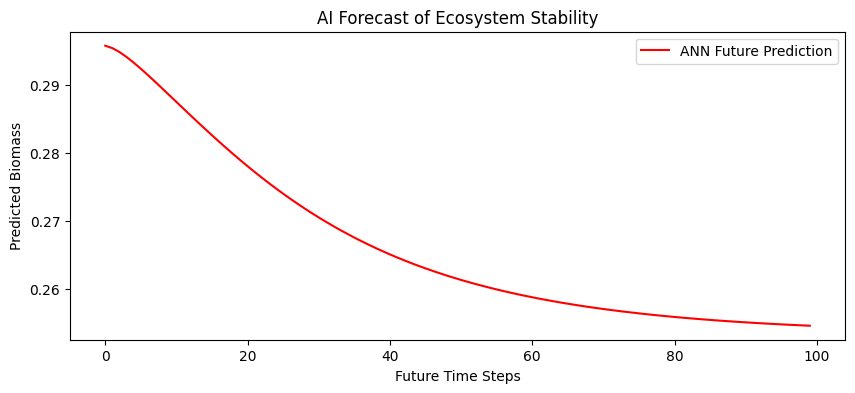

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

# --- 1. PREPARE DATA ---
# We will use the 'bacteria_over_time' data generated in Phase 2
data = bacteria_over_time.reshape(-1, 1)

# Normalize data (Neural Networks like numbers between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences (Use past 50 steps to predict the next 1)
X_train = []
y_train = []
look_back = 50

for i in range(look_back, len(scaled_data)):
    X_train.append(scaled_data[i-look_back:i, 0])
    y_train.append(scaled_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
# Reshape for LSTM [Samples, Time Steps, Features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# --- 2. BUILD THE ANN MODEL ---
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1)) # Predict next time step

model.compile(optimizer='adam', loss='mean_squared_error')

# --- 3. TRAIN ---
# This teaches the AI the "physics" of your biological model
print("Training Neural Network...")
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=0)
print("Training Complete.")

# --- 4. PREDICT THE FUTURE ---
# Let's predict the next 100 steps beyond the simulation
last_sequence = scaled_data[-look_back:]
future_predictions = []

for _ in range(100):
    input_seq = last_sequence.reshape((1, look_back, 1))
    next_step = model.predict(input_seq, verbose=0)
    future_predictions.append(next_step[0, 0])
    # Update sequence with new prediction
    last_sequence = np.append(last_sequence[1:], next_step)

# Inverse transform to get real biomass numbers
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot
plt.figure(figsize=(10, 4))
plt.plot(range(100), future_predictions, 'r-', label='ANN Future Prediction')
plt.title('AI Forecast of Ecosystem Stability')
plt.xlabel('Future Time Steps')
plt.ylabel('Predicted Biomass')
plt.legend()
plt.show()